### Summary: Generating Text with an Autoregressive Model

This notebook explores building an autoregressive text generation model, also known as a **Markov Model**, to generate text in the style of a given book. The lab begins by preprocessing text data from **Project Gutenberg**, using works like _Alice in Wonderland_ and _The Metamorphosis_, and sets up an autoregressive model where the probability of the next word is based on the previous $k$ words (k-gram). The goal is to balance grammatical structure while avoiding excessive copying from the source material.

Key components of the lab include:
- **Data Preprocessing**: Downloading and cleaning text from multiple books, preparing it for modeling by tokenizing and structuring sequences based on $k$-grams.
- **Model Implementation**: Constructing and training the autoregressive model to predict the next word based on the $k$ most recent words, demonstrating the impact of $k$ on the quality of generated text.
- **Quality vs. Plagiarism Trade-off**: Analyzing how smaller values of $k$ generate less coherent text, while larger values result in plagiarism as the model copies large text chunks from the original work. Experiments include measuring the **Longest Common Substring (LCS)** between generated and original text across different $k$ values.
- **Visualization and Evaluation**: Plotting LCS lengths to show how text similarity scales with $k$ and exploring the exponential growth in copying as $k$ increases. 
- **Model Improvement Challenge**: A bonus task invites modifications to the $k$-gram model, encouraging creativity to balance coherence and originality.

This hands-on lab provides a foundational understanding of probabilistic models for text generation and highlights the challenges and trade-offs involved in building language models.


Import libraries

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

Preprocessing the text data

In [2]:
#Code adapted from https://pypi.org/project/Gutenberg/ to help download from
#Project Gutenberg (www.gutenberg.org/) automatically. 
def _format_download_urls(etextno):
    """
    Returns the possible urls location on the Project Gutenberg servers for a
    given text. Mostly ripped from https://pypi.org/project/Gutenberg/.
    """
    uri_root = r'http://www.gutenberg.lib.md.us'

    if 0 < etextno < 10:
        oldstyle_files = (
            'when11',
            'bill11',
            'jfk11',
            'getty11',
            'const11',
            'liber11',
            'mayfl11',
            'linc211',
            'linc111',
        )
        etextno = int(etextno)
        return '{root}/etext90/{name}.txt'.format(
            root=uri_root,
            name=oldstyle_files[etextno - 1])

    else:
        etextno = str(etextno)
        extensions = ('.txt', '-8.txt', '-0.txt')
        urls = []
        for extension in extensions:
            uri = '{root}/{path}/{etextno}/{etextno}{extension}'.format(
                root=uri_root,
                path='/'.join(etextno[:len(etextno) - 1]),
                etextno=etextno,
                extension=extension)
            urls.append(uri)
        return urls
    
def download_from_book_id(bookid, bookname):

    book_dst = f'{bookname}.txt'
    
    import os
    from six.moves import urllib
    
    if os.path.isfile(book_dst):
      print('File %s is already downloaded' % book_dst)
    else:
      possible_urls = _format_download_urls(bookid)
      print(possible_urls)
      for url in possible_urls:
        print(f'trying {url}...')
        try:
          urllib.request.urlretrieve(url, book_dst)
          print(f'Downloaded {bookname}.txt, with book id {bookid}.')
          return
        except urllib.error.HTTPError:
          None
      raise NameError("Couldn't find that book on Gutenberg")

In [3]:
#downloading the books we'll use for the lab
download_from_book_id(100, "Shakespeare")
download_from_book_id(5200, "Metamorphosis")
download_from_book_id(11, "Wonderland")
download_from_book_id(1184, "MonteCristo")

['http://www.gutenberg.lib.md.us/1/0/100/100.txt', 'http://www.gutenberg.lib.md.us/1/0/100/100-8.txt', 'http://www.gutenberg.lib.md.us/1/0/100/100-0.txt']
trying http://www.gutenberg.lib.md.us/1/0/100/100.txt...
trying http://www.gutenberg.lib.md.us/1/0/100/100-8.txt...
trying http://www.gutenberg.lib.md.us/1/0/100/100-0.txt...
Downloaded Shakespeare.txt, with book id 100.
['http://www.gutenberg.lib.md.us/5/2/0/5200/5200.txt', 'http://www.gutenberg.lib.md.us/5/2/0/5200/5200-8.txt', 'http://www.gutenberg.lib.md.us/5/2/0/5200/5200-0.txt']
trying http://www.gutenberg.lib.md.us/5/2/0/5200/5200.txt...
trying http://www.gutenberg.lib.md.us/5/2/0/5200/5200-8.txt...
trying http://www.gutenberg.lib.md.us/5/2/0/5200/5200-0.txt...
Downloaded Metamorphosis.txt, with book id 5200.
['http://www.gutenberg.lib.md.us/1/11/11.txt', 'http://www.gutenberg.lib.md.us/1/11/11-8.txt', 'http://www.gutenberg.lib.md.us/1/11/11-0.txt']
trying http://www.gutenberg.lib.md.us/1/11/11.txt...
trying http://www.gutenbe

In [4]:
# inspecting one of the books to get a sense of the content of the files
file_handle = open("book text files for autoregressive model/Wonderland.txt", encoding="utf8")  # It's very important to mention utf8 encoding
wonderland_book_text = file_handle.read()  # Copies the book as a string in memory
file_handle.close()

print(wonderland_book_text[0:1000])

*** START OF THE PROJECT GUTENBERG EBOOK 11 ***
[Illustration]




Alice’s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the Rabbit-Hole
 CHAPTER II.    The Pool of Tears
 CHAPTER III.   A Caucus-Race and a Long Tale
 CHAPTER IV.    The Rabbit Sends in a Little Bill
 CHAPTER V.     Advice from a Caterpillar
 CHAPTER VI.    Pig and Pepper
 CHAPTER VII.   A Mad Tea-Party
 CHAPTER VIII.  The Queen’s Croquet-Ground
 CHAPTER IX.    The Mock Turtle’s Story
 CHAPTER X.     The Lobster Quadrille
 CHAPTER XI.    Who Stole the Tarts?
 CHAPTER XII.   Alice’s Evidence




CHAPTER I.
Down the Rabbit-Hole


Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into
the book her sister was reading, but it had no pictures or
conversations in it, “and what is the use of a book,” thought Alice
“without pictures or conversations?”

So she was considering in her 

writing a function to convert the files into strings of one word length, only taking the actual book content and dropping the metadata at the beginning and end of the files

In [5]:
def word_sequence_from_file(filepath):

    # Open the file
    file_handle = open(filepath, encoding="utf8")
    raw_book_text = file_handle.read()  # Copies the book as a string in memory
    file_handle.close()

    start = '*** START OF THE PROJECT GUTENBERG EBOOK'
    end = '*** END OF THE PROJECT GUTENBERG EBOOK'
    
    startInd = raw_book_text.find(start) + len(start)
    endInd = raw_book_text.find(end) + len(end)
    
    book_text = raw_book_text[startInd:endInd+1]
    word_sequence = book_text.split()

    return word_sequence

In [6]:
# converting the books into word sequence lists
shakespeare = word_sequence_from_file("book text files for autoregressive model/Shakespeare.txt")
metamorphosis = word_sequence_from_file("book text files for autoregressive model/Metamorphosis.txt")
wonderland = word_sequence_from_file("book text files for autoregressive model/Wonderland.txt")
montecristo = word_sequence_from_file("book text files for autoregressive model/MonteCristo.txt")

In [7]:
#printing the first 100 words of the wonderland book to test the function
display(" ".join(wonderland[1:100]))

'*** [Illustration] Alice’s Adventures in Wonderland by Lewis Carroll THE MILLENNIUM FULCRUM EDITION 3.0 Contents CHAPTER I. Down the Rabbit-Hole CHAPTER II. The Pool of Tears CHAPTER III. A Caucus-Race and a Long Tale CHAPTER IV. The Rabbit Sends in a Little Bill CHAPTER V. Advice from a Caterpillar CHAPTER VI. Pig and Pepper CHAPTER VII. A Mad Tea-Party CHAPTER VIII. The Queen’s Croquet-Ground CHAPTER IX. The Mock Turtle’s Story CHAPTER X. The Lobster Quadrille CHAPTER XI. Who Stole the Tarts? CHAPTER XII. Alice’s Evidence CHAPTER I. Down the Rabbit-Hole Alice was beginning to get very tired of sitting'

To build the model, we need to create an autoregressive model that uses a probabilistic approach to predict the next word in a sequence based on the previous $k$ words. The model will be trained on the text data from one of the books we downloaded. We will use a dictionary to store the probabilities of each word given the previous $k$ words. The model will generate text by predicting the next word based on the last $k$ words and then updating the sequence to include the new word. 

In [8]:
# create a dictionary that stores the probabilities of each word given the previous k words
def make_freq_dict(k, word_sequence):

    # Make empty dict to count frequencies
    freq_dict = dict()

    #loop through all k-grams
    for i in range(len(word_sequence) - k -1):
        Kgram = " ".join(word_sequence[i:i+k])
        Next = word_sequence[i+k]
        
        if Kgram in freq_dict:
            if Next in freq_dict[Kgram]:
                freq_dict[Kgram][Next] += 1
            else:
                freq_dict[Kgram][Next] = 1
        else:
            freq_dict[Kgram] = {Next: 1}

    return freq_dict

In [9]:
#function to predict the next word given a frequency dictionary and a k-gram of words
def predict_next_word(this_kgram, freq_dict):
    
    if this_kgram not in freq_dict:
        return None
    else:
        total = 0
        nextWordOptions = []
        prob = []
        #find probability of each possible next word  
        for nextWord, count in freq_dict[this_kgram].items():
            total += count
        for nextWord,count in freq_dict[this_kgram].items():
            nextWordOptions.append(nextWord)
            prob.append(count/total)
        return random.choices(nextWordOptions, weights = prob, k = 1)[0]

In [10]:
# function to predict a full paragraph of text given a frequency dictionary and an initial k-gram of words selected from the text

def predict_paragraph(start_kgram, k, freq_dict, gen_length=300):

    gen_para = list(start_kgram)
    currKgram = " ".join(start_kgram)
    for i in range(gen_length-k):
        nextWord = predict_next_word(currKgram, freq_dict)
        
        #make sure there is a next word to append to the paragraph
        if nextWord is None:
            break
        gen_para.append(nextWord)
        currKgram = " ".join(gen_para[-k:])

    return gen_para

In [11]:
# test the code generating a paragraph of text from The Metamorphosis

# Pick k and make a frequency dictionary from Metamorphosis.
k_test = 3

freq_dict_test = make_freq_dict(k_test, metamorphosis)

# pick a random starting k-gram from the freq-dict.
start_test = random.choice(list(freq_dict_test.keys())).split()

# Alternatively, pick the start of the book as the first k-gram
# start_test = metamorphosis[0:k_test]

# Generate a paragraph, and print it.
gen_paragraph = predict_paragraph(start_test, k_test, freq_dict_test)
" ".join(gen_paragraph)

'room. “You’ll have to go for the doctor straight away. Gregor is ill. Quick, get the doctor. Did you hear the way Gregor spoke just now?” “That was the voice of his superior even here. The uniform had not been working—the first holiday in a life that had been on it—of the lady dressed in copious fur. He hurried up onto the picture and pressed himself against it so that everything really looked as if he were being assailed from all sides. With his head and legs pulled in against him and his family depended on it! If only his sister had certainly left it there for him because of that, but he turned, almost against his own will, away from the dish and crawled back into the centre of the room. Through the crack in the door, Gregor could see that the gas had been lit in the living room. His father at this time would normally be sat with his evening paper, reading it out in a loud voice to Gregor’s mother, and sometimes to his sister, but there was now more than one father behind him; it wa

The below section is ***NOT MY CODE***, it was given for the assignment to find the length of the longest common substring (LCS) of a generated paragraph and the book used to generate it. This allows us to eplore the tradeoffs between model complexity and output (more accurate and "real-seeming" text generation vs. more plagiarism).

In [12]:
# GIVEN CODE to find longest common substring
from IPython.display import display, Markdown #

# Colors to use in the Markdown Text
md_colors = ["#009292", "#FF6DB6", "#490092", "#006DDB", "#B66DFF", "#920000", "#DB6D00"]

def list_of_seqs_to_markdown(list_of_sequences):
    """
    Takes in a list-of-list-of-strings, and colors each sublist with a single
    color cycling through the list `md_colors` to pick those colors

    :param      list_of_sequences:  List of list of words
    :type       list_of_sequences:  List of list of words
    """

    # The output string
    display_string = ""
    for i, word_sequence in enumerate(list_of_sequences):
        display_string = display_string + f'<font color={md_colors[i % len(md_colors)]}>{" ".join(word_sequence)}</font> '

    # Draw that string with Markdown
    display(Markdown(display_string))


class LcsFinder:
    """
    Internally, this class takes `word_sequence` and
    builds a hash table from any k-gram that appears in
    `word_sequence` to the list of all indices where that
    k-gram appears in `word_sequence`. This makes finding
    the LCS pretty fast.
    It also stores a set of all less-than-k grams that appear
    in the text, but just as a set and not as a hash table.
    """

    def __init__(self, word_sequence, k=3):
        """
        By default, this hash table uses 3-grams, this seems to work well. Feel
        free to pass in a different k-value, though keep in mind this is a
        heuristic speedup, and is unrelated to the k-gram from the language
        model.

        :param      word_sequence:  A book
        :type       word_sequence:  List of strings
        :param      k:              Heuristic k-gram size for efficient lookup
        :type       k:              int
        """
        self.k = k
        self.word_sequence = word_sequence
        self.index_hash = dict()
        self.short_gram_set = set()

        for i in range(len(word_sequence)-k):

            k_gram = " ".join(word_sequence[i:i+k])  # Build this k-gram
            if k_gram not in self.index_hash:
                self.index_hash[k_gram] = []  # Add it to the hash table if it ain't there
            self.index_hash[k_gram].append(i)  # And add the index to the list

            # Update the set of short grams with all possible grams starting at i, and with length < k.
            self.short_gram_set.update({" ".join(word_sequence[i:i+j]) for j in range(1,k)})

    def length_of_lcs_from_start(self, small_sequence, start_idx):
        """
        Look for the longest common substring of word_sequence and
        small_sequence, subject to the substring starting at
        `small_sequence[start_idx]`. Returns the length of this LCS, measured in
        words.

        :param      small_sequence:  A small word sequence
        :type       small_sequence:  List of strings
        :param      start_idx:       The index where the LCS has to start at
        :type       start_idx:       int

        :returns:   Length of the LCS, measure in words
        :rtype:     int
        """

        # Build the k-gram rooted at start_idx
        start_k_gram = " ".join(small_sequence[start_idx:start_idx+self.k])

        # If the k-gram is in the big hash table,
        if start_k_gram in self.index_hash:

            longest = 0

            # Scan over all indices in the list in the hash table
            for word_seq_index in self.index_hash[start_k_gram]:

                # While loop, starting at size k, expanding the length of the LCS until the sequences stop matching
                i = self.k
                while (word_seq_index + i < len(self.word_sequence) and # in-bounds on word_sequence
                       start_idx + i < len(small_sequence) and # in-bounds on small_sequence
                       self.word_sequence[word_seq_index + i] == small_sequence[start_idx + i]): # the words are the same
                    i = i+1

                # The length of the longest LCS seen so far is kept
                longest = max(longest, i)
            return longest
        else:
            # If the k-gram ain't in the big hash table, check if it's sub-grams are in the stored set
            for i in range(self.k-1,0,-1): # In order from k-1 to 1
                if " ".join(small_sequence[start_idx:start_idx+i]) in self.short_gram_set:
                    return i
            return 0

    def lcs_length(self, small_sequence):
        """
        Given `small_sequence`, a list of strings, this returns the length of
        the longest common substring between `small_sequence` and
        `word_sequence`

        :param      small_sequence:  A small sequence of words
        :type       small_sequence:  List of strings

        :returns:   Length of the LCS, measured in words
        :rtype:     int
        """
        longest = 0

        # Just iterative over all starting words in `small_sequence` and keep the biggest number
        for i in range(len(small_sequence)):
            sequence_len = self.length_of_lcs_from_start(small_sequence, i)
            longest = max(longest, sequence_len)

        return longest

    # Given `small_sequence`, a list of strings, this prints highlighted markdown that shows where one substring of `word_sequence` ends and the next one starts. If a word doesn't appear in `word_sequence`, we just treat it like a substring of length 1.

    def greedy_lcs_markdown(self, small_sequence):
        """
        Given `small_sequence`, a list of strings, this prints highlighted
        markdown that shows where one substring of `word_sequence` ends and the
        next one starts. If a word doesn't appear in `word_sequence`, we just
        treat it like a substring of length 1.

        :param      small_sequence:  A small sequence of words
        :type       small_sequence:  List of strings

        :returns:   Markdown display text (renders by default on Jupyter)
        :rtype:     Markdown display text
        """
        list_of_sequences = []  # The output list

        i = 0
        while i < len(small_sequence):
            # iteratate over small_sequence, finding the lcs rooted at index i,
            # and color that LCS accordingly.
            sequence_len = max(self.length_of_lcs_from_start(small_sequence, i), 1)
            list_of_sequences.append(small_sequence[i:i+sequence_len])
            i = i + sequence_len

        return list_of_seqs_to_markdown(list_of_sequences)

Now we can use the `LcsFinder` class to find the length of the longest common substring between a generated paragraph and the book used to generate it. 

In [13]:
# Build an LcsFinder for Metamorphosis
metamorphosis_finder = LcsFinder(metamorphosis)

# Use the LcsFinder to find the LCS length in the generated paragraph
print(f'LCS length: {metamorphosis_finder.lcs_length(gen_paragraph)} words')

# Use the LcsFinder to highlight substrings in the generated text that appear in the original text.
metamorphosis_finder.greedy_lcs_markdown(gen_paragraph)

LCS length: 84 words


<font color=#009292>room. “You’ll have to go for the doctor straight away. Gregor is ill. Quick, get the doctor. Did you hear the way Gregor spoke just now?” “That was the voice of</font> <font color=#FF6DB6>his superior even here. The uniform had not been</font> <font color=#490092>working—the first holiday in a life that had been</font> <font color=#006DDB>on it—of the lady dressed in copious fur. He hurried up onto the picture and pressed himself against</font> <font color=#B66DFF>it so that everything really looked as if</font> <font color=#920000>he were being assailed from all sides. With his head and legs pulled in against him and his</font> <font color=#DB6D00>family depended on it! If only his sister</font> <font color=#009292>had certainly left it there for him because of that, but he turned, almost against his own will, away from the dish and crawled back into the centre of the room. Through the crack in the door, Gregor could see that the gas had been lit in the living room. His father at this time would normally be sat with his evening paper, reading it out in a loud voice to Gregor’s mother, and sometimes to his sister, but there was now</font> <font color=#FF6DB6>more than one father behind him; it was not</font> <font color=#490092>possible for human beings to live with an animal like that and he would</font> <font color=#006DDB>disappear. His father, though, was not in the mood to</font> <font color=#B66DFF>look after it and be patient, I don’t think anyone could accuse us of doing anything wrong.” “She’s absolutely right”, said Gregor’s father to himself. His mother, who still had not had time to</font> <font color=#920000>give more attention to Gregor than was absolutely necessary? The household budget became even smaller; so now the maid was dismissed; an enormous, thick-boned charwoman with white hair that flapped around her head came every morning and evening to do the</font> <font color=#DB6D00>job himself. And without considering that he still was</font> 

This section explores the trade-off between coherence and originality in text generation using different values of $k$ (previous words in the Markov model). Smaller $k$ values produce incoherent text, while larger $k$ values lead to excessive copying from the original text. 

To quantify this, the lab generates 100 paragraphs of 300 words for each of five $k$ values and calculates the **Longest Common Substring (LCS)** lengths between the generated paragraphs and the original book. It then analyzes the 25th percentile, median, and 75th percentile of LCS lengths to visualize how $k$ affects this balance.


In [14]:
# Which values of k to generate k-grams for and estimate LCS lengths with
ks_to_plot = [1, 2, 3, 4, 5]

def gen_lcs_statistics(word_sequence):

    n_trials = 100  # number of trials
    gen_length_test = 300  # number of words to generate

    lcs_lengths = np.zeros((len(ks_to_plot), n_trials))
    lcs_finder = LcsFinder(word_sequence)

    for k in ks_to_plot:
        freqDict = make_freq_dict(k, word_sequence)
        for i in range(n_trials):
            start = random.choice(list(freqDict.keys())).split()
            genPara = predict_paragraph(start, k, freqDict, gen_length_test)
            " ".join(genPara)
            lcs = lcs_finder.lcs_length(genPara)
            lcs_lengths[k-1,i] = lcs
            
    lcs_length_bots, lcs_length_medians, lcs_length_tops = np.quantile(lcs_lengths, [0.25, 0.5, 0.75], axis = 1)
    
     
    return {"top_quartiles": lcs_length_tops, "medians": lcs_length_medians, "bot_quartiles": lcs_length_bots}

In [15]:
# test code using Shakespeare text file
gen_lcs_statistics(shakespeare)


{'top_quartiles': array([  5.  ,  15.  ,  54.25, 193.75, 300.  ]),
 'medians': array([  4.,  13.,  46., 158., 300.]),
 'bot_quartiles': array([  4.  ,  11.  ,  37.  , 117.5 , 221.75])}

Visualizing the trade-off between coherence and originality in text generation by plotting the average LCS lengths for each $k$ value of 300 generated paragraphs from a given text. The plot shows how the LCS length increases with $k$, indicating a trade-off between coherence and originality in text generation.

In [16]:
#define function to plot k vs LCS length
def plot_lcs_statistics(word_sequence, book_title, lcs_stats):
    """
    Given a book, it's title, and the LCS statistics generated by
    `gen_lcs_statistics`, this renders a plot to visualize the statistics.

    :param      word_sequence:  The book
    :type       word_sequence:  List of string
    :param      book_title:     The book's title
    :type       book_title:     String
    :param      lcs_stats:      The lcs statistics
    :type       lcs_stats:      Dict that maps string to numpy array
    """

    ## TODO: WRITE THIS CODE
    ## Use plot() to render the median as one line
    ## Use fill_between() to shade the area 25th and 75th quartiles with a low alpha value, like alpha=0.35
    plt.plot(ks_to_plot, lcs_stats["medians"], linewidth = 2, color = 'darkblue')
    
    plt.ylim(0,350)
    plt.fill_between(ks_to_plot, lcs_stats["top_quartiles"], lcs_stats["bot_quartiles"], color = 'blue', alpha=0.2)
    
    plt.xlabel('k')
    plt.ylabel('LCS Length in Words')
    plt.title(book_title + ': k vs length of LCS')

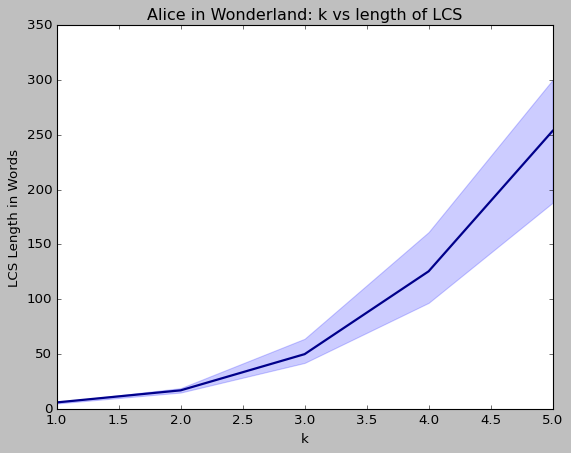

In [17]:
#plot for Wonderland book
plot_lcs_statistics(wonderland, "Alice in Wonderland", gen_lcs_statistics(wonderland))

In [18]:
#function to plot multiple k vs LCS length plots for different books

plot_colors = ["#009292", "#FF6DB6", "#490092", "#006DDB", "#B66DFF", "#6DB6FF", "#B6DBFF", "#920000", "#924900", "#DB6D00", "#24FF24", "#FFFF6D"]

def plot_many_lcs_statistics(list_of_dicts):

    fig, ax = plt.subplots(1, 1, figsize = (10,6))
    
    for i in range(len(list_of_dicts)):
        ax.plot(ks_to_plot, list_of_dicts[i]["stats"]["medians"], linewidth = 2, color = plot_colors[i], label=list_of_dicts[i]["book_name"])
        ax.fill_between(ks_to_plot, list_of_dicts[i]["stats"]["top_quartiles"], list_of_dicts[i]["stats"]["bot_quartiles"], color=plot_colors[i], alpha = 0.15)
        
    ax.set_ylim(0,350)
    ax.set_xlabel('k')
    ax.set_ylabel('LCS Length in Words')
    ax.set_title('k vs Length of LCS')
    ax.legend(loc = 'best')
    plt.show()


In [20]:
#generate statistics for all books
shakes_stats = gen_lcs_statistics(shakespeare)
metamorphosis_stats = gen_lcs_statistics(metamorphosis)
wonderland_stats = gen_lcs_statistics(wonderland)
monte_cristo_stats = gen_lcs_statistics(montecristo)

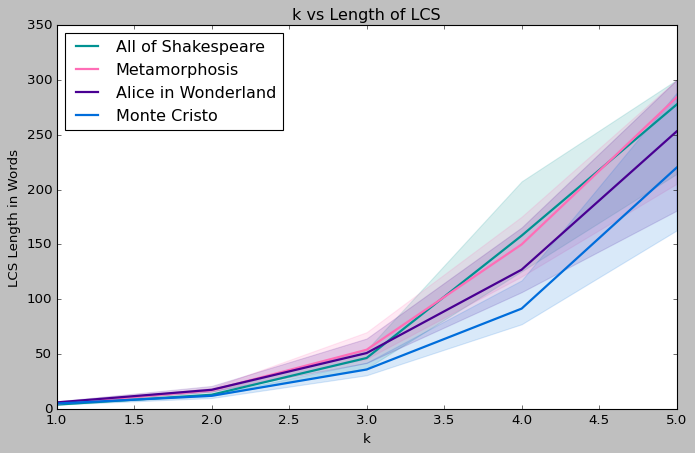

In [21]:
#plot for all books used in lab
plot_many_lcs_statistics(
    [
        {
            "book_name": "All of Shakespeare",
            "stats": shakes_stats
        }, {
            "book_name": "Metamorphosis",
            "stats": metamorphosis_stats
        }, {
            "book_name": "Alice in Wonderland",
            "stats": wonderland_stats
        }, {
            "book_name": "Monte Cristo",
            "stats": monte_cristo_stats
        }
    ]
)

Lastly, we are asked to come up with our own way of improving the LCS length of the model using a method we come up with or found via research (I found mine looking through documentation on impriving LCS length from *rdrr.io*. To improve the model's LCS length for a given k-gram length, I applied **temperature scaling** to adjust the probabilities of selecting the next word. By increasing the temperature value, I smoothed the probability distribution, making the model less likely to choose the most frequent word and more likely to explore other options. This approach aimed to reduce exact copying from the original text and create more diverse and original paragraphs while maintaining some coherence. I updated the `predict_next_word` function to incorporate temperature scaling and tested the effect on LCS lengths compared to the standard model.


In [22]:
# update predict next word function to include temperature scaling when assigning probabilities
def predict_next_word_temp_scaled(this_kgram, freq_dict):
    
    temp = 1.4
    
    if this_kgram not in freq_dict:
        return None
    else:
        total = 0
        nextWordOptions = []
        prob = []
        #find probability of each possible next word  
        for nextWord, count in freq_dict[this_kgram].items():
            total += count
        for nextWord,count in freq_dict[this_kgram].items():
            nextWordOptions.append(nextWord)
            prob.append(count/total)
        
        #recalc with temp
        probTemp = np.exp(np.log(prob) / temp)
        
        #normalize probs
        probTemp /= np.sum(probTemp)
        
        return random.choices(nextWordOptions, weights = probTemp, k = 1)[0]

In [23]:
# update gen paragraph function with new predict next word function
def predict_paragraph_temp_scaled(start_kgram, k, freq_dict, gen_length=300):

    gen_para = list(start_kgram)
    currKgram = " ".join(start_kgram)
    for i in range(gen_length-k):
        nextWord = predict_next_word_temp_scaled(currKgram, freq_dict)
        
        if nextWord is None:
            break
        gen_para.append(nextWord)
        currKgram = " ".join(gen_para[-k:])
    
    return gen_para

In [24]:
# test both methods on shakespeare. print two text examples with LCS length and then plot for 100 trials over all options for k

k_test = 3

freq_dict_test = make_freq_dict(k_test, shakespeare)

# pick a random starting k-gram from the freq-dict.
start_test = random.choice(list(freq_dict_test.keys())).split()

# Generate a paragraph, and print it.
gen_paragraph = predict_paragraph(start_test, k_test, freq_dict_test)
" ".join(gen_paragraph)

gen_paragraph_temp_scaled = predict_paragraph_temp_scaled(start_test, k_test, freq_dict_test)
" ".join(gen_paragraph_temp_scaled)

shakespeare_finder = LcsFinder(shakespeare)

# Use the LcsFinder to find the LCS length in the generated paragraph
print(f'LCS length original: {shakespeare_finder.lcs_length(gen_paragraph)} words')
print(f'LCS length temp scaled: {shakespeare_finder.lcs_length(gen_paragraph_temp_scaled)} words')
print()

# Use the LcsFinder to highlight substrings in the generated text that appear in the original text.
print('paragraph w/ no temp scaling:')
shakespeare_finder.greedy_lcs_markdown(gen_paragraph)
print('paragraph w/ temp scaling:')
shakespeare_finder.greedy_lcs_markdown(gen_paragraph_temp_scaled)  

LCS length original: 37 words
LCS length temp scaled: 34 words

paragraph w/ no temp scaling:


<font color=#009292>use it. SHYLOCK. When Jacob graz’d his uncle Laban’s sheep,— This Jacob from our holy Abram was As his wise mother wrought in his behalf, The third possessor; ay, he was the third. ANTONIO. And what of</font> <font color=#FF6DB6>him, Tranio? TRANIO. If he be</font> <font color=#490092>noble Arcite, thousand ways! Were I at liberty, I would do</font> <font color=#006DDB>such a wrong for the whole</font> <font color=#B66DFF>to be imagined. And from the</font> <font color=#920000>organ-pipe of frailty sings His soul and body</font> <font color=#DB6D00>rive not more in</font> <font color=#009292>joy at first hearing he was a</font> <font color=#FF6DB6>man. But now I’ll tell thee</font> <font color=#490092>all my whole device When I am</font> <font color=#006DDB>sure you know how much the</font> <font color=#B66DFF>estate is green and yet ungoverned. Where every horse bears his commanding rein And may direct his course as please himself, As well the fear of</font> <font color=#920000>God on the left hand,</font> <font color=#DB6D00>a seat being left void above him, as for Canterbury’s seat. Duke of Suffolk,</font> <font color=#009292>And girt thee with the</font> <font color=#FF6DB6>fall? MARTIUS. O brother, with the dismall’st object hurt That ever eye with sight made heart lament! AARON. [_Aside_.] Now will I</font> <font color=#490092>stir this gamester. I hope I</font> <font color=#006DDB>dream; For so I</font> <font color=#B66DFF>know he is, they know he is— A most arch heretic, a pestilence That does infect the land; with which they, moved, Have broken with the King,</font> <font color=#920000>To lay aside life-harming heaviness And entertain a</font> <font color=#DB6D00>score or two of</font> <font color=#009292>these! SANDYS. I would I</font> <font color=#FF6DB6>had some flowers o’ th’</font> <font color=#490092>season Are our carnations and streak’d gillyvors, Which some call nature’s bastards: of that kind Our rustic garden’s barren; and I care not</font> <font color=#006DDB>for thee. KENT. Pray do not, sir: I have watch’d, and travell’d hard; Some time I shall</font> <font color=#B66DFF>not need it if he have</font> <font color=#920000>no wife! There’s nothing here that is too good</font> <font color=#DB6D00>to be Where ill men were, and was the best</font> 

paragraph w/ temp scaling:


<font color=#009292>use it. SHYLOCK. When Jacob graz’d his uncle Laban’s sheep,— This Jacob from our holy Abram was As his wise mother wrought in his behalf, The third possessor; ay, he was the</font> <font color=#FF6DB6>lord Of this fair</font> <font color=#490092>couple—meets he on the way</font> <font color=#006DDB>a little, And say if I shall</font> <font color=#B66DFF>be post indeed, For she will score your fault upon my pate. Methinks your maw, like mine, should be your</font> <font color=#920000>patient to follow your prescriptions, the wise may make some dram of a scruple,</font> <font color=#DB6D00>no obstacle, no incredulous or unsafe circumstance. What can be said? Nothing that can be can come between me and the</font> <font color=#009292>peers; And be thou he. MESSENGER. With all my</font> <font color=#FF6DB6>force, pursuit, and policy. AENEAS. And thou shalt</font> <font color=#490092>find me sad and solitary. [_Exit._] JULIA. How many women</font> <font color=#006DDB>saw this child of his? AARON. Why, so, brave lords! When we join in league, I am a</font> <font color=#B66DFF>peppercorn, a brewer’s horse. The inside of a church! Company, villainous company, hath been the spoil of me. BARDOLPH. Sir John, you</font> <font color=#920000>live in great infamy. FALSTAFF. He that buckles himself in my belt cannot live in less. CHIEF JUSTICE. Your means are very slender, and your waste is great. FALSTAFF. I would</font> <font color=#DB6D00>all the world should</font> <font color=#009292>so much differ, And we alive that lived? Fly, damned baseness, To him that</font> <font color=#FF6DB6>ever fears he shall be</font> <font color=#490092>King. SMITH. Sir, he made a</font> <font color=#006DDB>good pantler; he would ha’ chipped bread well. DOLL. They say Poins has a good</font> <font color=#B66DFF>face, speaks well and has excellent good clothes: there’s no farther necessity of qualities can make her be refused. BAWD. What is her</font> <font color=#920000>burying grave, that is her womb: And from her</font> <font color=#DB6D00>twining arms doth urge releasing: 256 “Pity,” she cries; “some favour, some remorse!” Away he springs, and hasteth to his horse. But lo</font> 

In [25]:
#testing using a large sample size of generated paragraphs to evaluate effectiveness of temperature scling here
# get average difference across 100 tests - turns out this doesn't really work
tests = 150

shakespeare_finder = LcsFinder(shakespeare)
tempTotalLCS = 0
origTotalLCS = 0
totalDiff = 0

for i in range(tests):
    start_test = random.choice(list(freq_dict_test.keys())).split()
    gen_paragraph = predict_paragraph(start_test, k_test, freq_dict_test)
    " ".join(gen_paragraph)

    gen_paragraph_temp_scaled = predict_paragraph_temp_scaled(start_test, k_test, freq_dict_test)
    " ".join(gen_paragraph_temp_scaled)
    
    origTotalLCS += shakespeare_finder.lcs_length(gen_paragraph)
    tempTotalLCS += shakespeare_finder.lcs_length(gen_paragraph_temp_scaled)

avgOrigLCS = origTotalLCS/tests
avgTempLCS = tempTotalLCS/tests

avgDiff = avgOrigLCS - avgTempLCS

print("average LCS length Original: " + str(avgOrigLCS))
print("average LCS length TempScaled: " + str(avgTempLCS))
print("average difference: " + str(avgDiff))

average LCS length Original: 49.74
average LCS length TempScaled: 48.653333333333336
average difference: 1.086666666666666


Ultimately, the temperature scaling approach did not work particularly well. This method likely didn't improve LCS length because, while it introduces more variability in word choice, it doesn't fundamentally change the structure of the generated text. The model still relies heavily on the k-gram frequencies from the original text, meaning that it can still copy long segments if they are common enough. Additionally, increasing temperature too much may disrupt grammatical coherence without sufficiently reducing copying, leading to incoherent but still plagiaristic text. Therefore, more sophisticated methods beyond temperature scaling are needed to balance originality and structure effectively.
 